# Set up and Import the data

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime


from random import gauss
from random import seed
import random
import numpy as np
from pandas import Series
from pandas import read_csv
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [2]:
#!pip install --upgrade pandas statsmodels

In [3]:
# Get Historical Intuit Data since 2015

intuit_data = yf.download("INTU", start="2015-01-01")

# Add daily returnsolumn
intuit_data['Daily_Return'] = intuit_data['Close'].pct_change()

intuit_close = intuit_data["Close"]

YF.download() has changed argument auto_adjust default to True



*********************100%***********************]  1 of 1 completed

In [4]:
# Display the first few rows of data
display(intuit_data.head())

print()

# Display the first few rows of data
display(intuit_close.head())


Price,Close,High,Low,Open,Volume,Daily_Return
Ticker,INTU,INTU,INTU,INTU,INTU,
Date,,,,,,
2015-01-02,83.803764,85.595429,83.031976,84.722565,1880300,NaN
2015-01-05,83.473007,83.923217,82.453138,82.967671,2493300,-0.003947
2015-01-06,80.909554,83.794586,80.496096,83.436254,2283800,-0.030710
2015-01-07,81.701965,82.042892,80.964837,81.056977,1657600,0.009794
2015-01-08,82.798454,83.507942,82.116608,82.171891,1947100,0.013421


Ticker,INTU
Date,
2015-01-02,83.803764
2015-01-05,83.473007
2015-01-06,80.909554
2015-01-07,81.701965
2015-01-08,82.798454


In [5]:
#Summary Stats for the Daily Close Price
display(intuit_close.describe())

Ticker,INTU
count,2579.000000
mean,313.491002
std,187.407021
min,73.961502
25%,130.790276
50%,268.130127
75%,459.383743
max,705.076782


#  Time series decomposition

In [6]:
# Decomposition
additive_decomposition = sm.tsa.seasonal_decompose(intuit_close, model='additive', period=252)
multiplicative_decomposition = sm.tsa.seasonal_decompose(intuit_close, model='multiplicative', period=252)

# Time Series Visualization

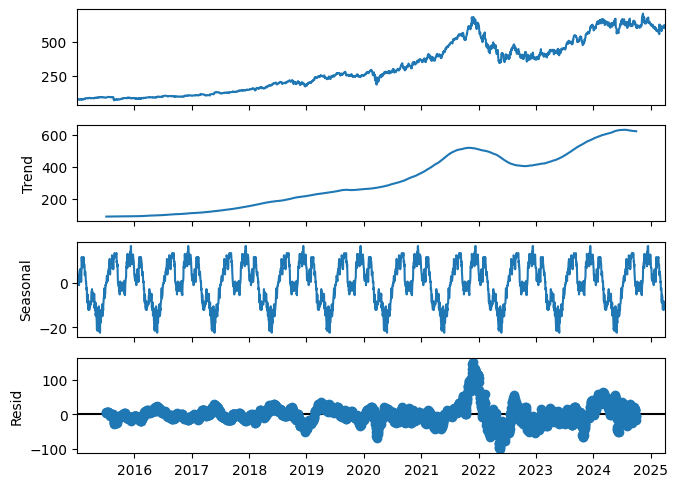

In [7]:
# Plot the additive decomposition
fig = additive_decomposition.plot()
fig.set_size_inches(7, 5)  # Adjust these numbers as needed (width, height)
plt.show()

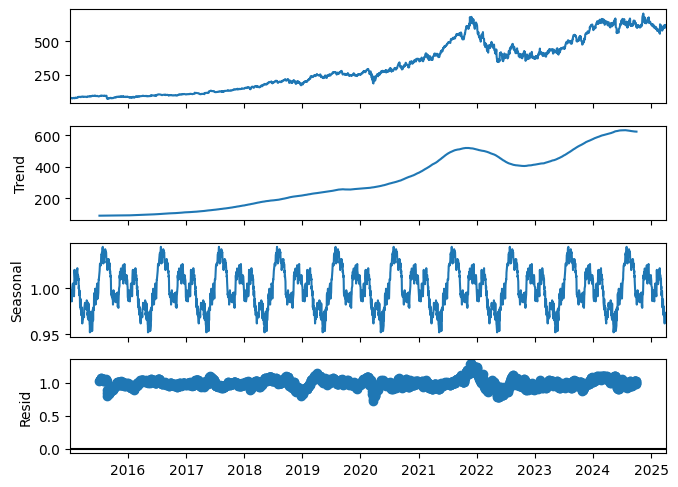

In [8]:
# Plot the multiplicative decomposition
fig = multiplicative_decomposition.plot()
fig.set_size_inches(7, 5)  # Adjust these numbers as needed (width, height)
plt.show()

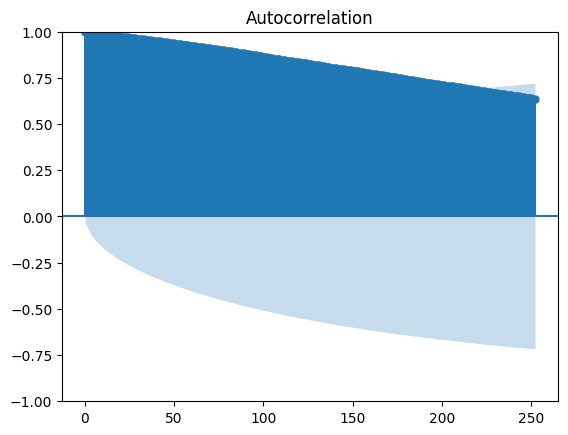

In [9]:
# Autocorrelation
plot_acf(intuit_close, lags=252)
plt.show()

Highly correclated at lag 1 and then decays over time


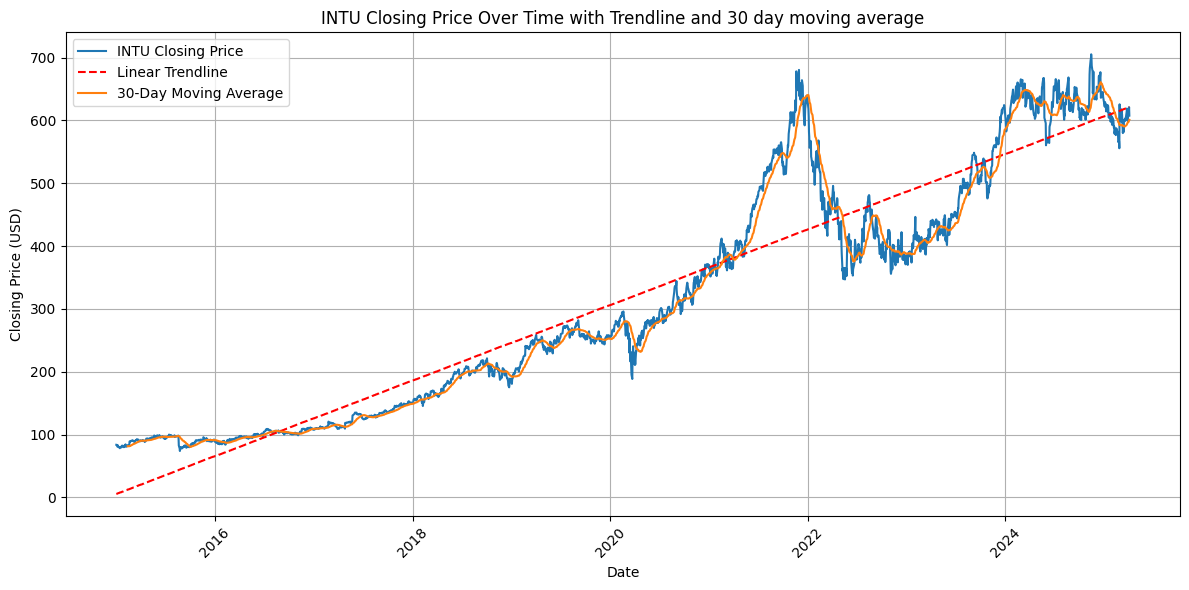

In [10]:
# Line Chart
plt.figure(figsize=(12, 6))
plt.plot(intuit_data.index, intuit_data['Close'], label='INTU Closing Price')

# Linear Trend
x = np.arange(len(intuit_data.index))
z = np.polyfit(x, intuit_data['Close'], 1)
p = np.poly1d(z.flatten())
plt.plot(intuit_data.index, p(x), "r--", label='Linear Trendline')

# Calculate 30-day moving average
intuit_data['30_day_avg'] = intuit_data['Close'].rolling(window=30).mean()['INTU']
plt.plot(intuit_data.index, intuit_data['30_day_avg'], label='30-Day Moving Average')


plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.title('INTU Closing Price Over Time with Trendline and 30 day moving average')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


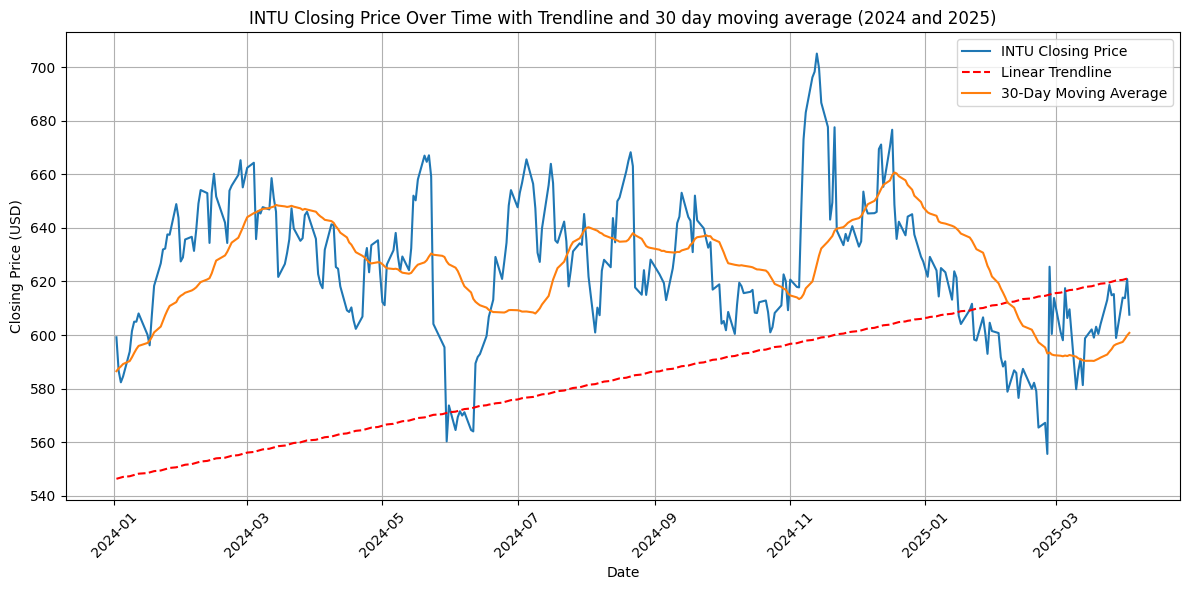

In [11]:
# Line Chart
# Same data as before but starting 2024 so we can see the last year
intuit_data_2024 = intuit_data[intuit_data.index > '2024-01-01']

plt.figure(figsize=(12, 6))
plt.plot(intuit_data_2024.index, intuit_data_2024['Close'], label='INTU Closing Price')

# Linear Trend
y_plot = p(x)[intuit_data.index > '2024-01-01']
plt.plot(intuit_data_2024.index, y_plot, "r--", label='Linear Trendline')

# Calculate 30-day moving average
plt.plot(intuit_data_2024.index, intuit_data_2024['30_day_avg'], label='30-Day Moving Average')


plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.title('INTU Closing Price Over Time with Trendline and 30 day moving average (2024 and 2025)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Description of Time series

As seen before the time series seems to have an overall upward trend, though this trend has become unstable starting around 2012. There is seasonality in the data, though it only accounts for a small portion of the data. The data is non-stationary since the mean as well as the variance seem to change over time.

# TS models

In [12]:
# Let's set aside the data starting July 2024 to compare with our forecasts.
data_train = intuit_close[intuit_close.index < '2024-06-01'].rename(columns={'INTU': 'Close'})
data_test = intuit_close[intuit_close.index >= '2024-06-01'].rename(columns={'INTU': 'Close'})

future_days = data_test.index.to_series()

print(data_train.shape, data_test.shape)

(2369, 1) (210, 1)


In [13]:
# Helper function for plotting forecasts
def plot_prediction(train, prediction, test, forecast_type = ''):
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train['Close'], label='Train Price')

    plt.plot(prediction.index, prediction['Close'], "r--", label='Forecast Price')

    plt.plot(test.index, test['Close'], label='Actual Test Price')


    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')
    plt.title('INTU Closing Price Forecast vs Actual ' + forecast_type)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def print_accuracy_scores(prices_test, prices_pred):
    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(prices_test, prices_pred))
    mae = mean_absolute_error(prices_test, prices_pred)
    r2 = r2_score(prices_test, prices_pred)

    print('-------------Accuracy Scores-------------')
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R-squared: {r2:.2f}")

Now we'll look at some naive methods as benchmarks.

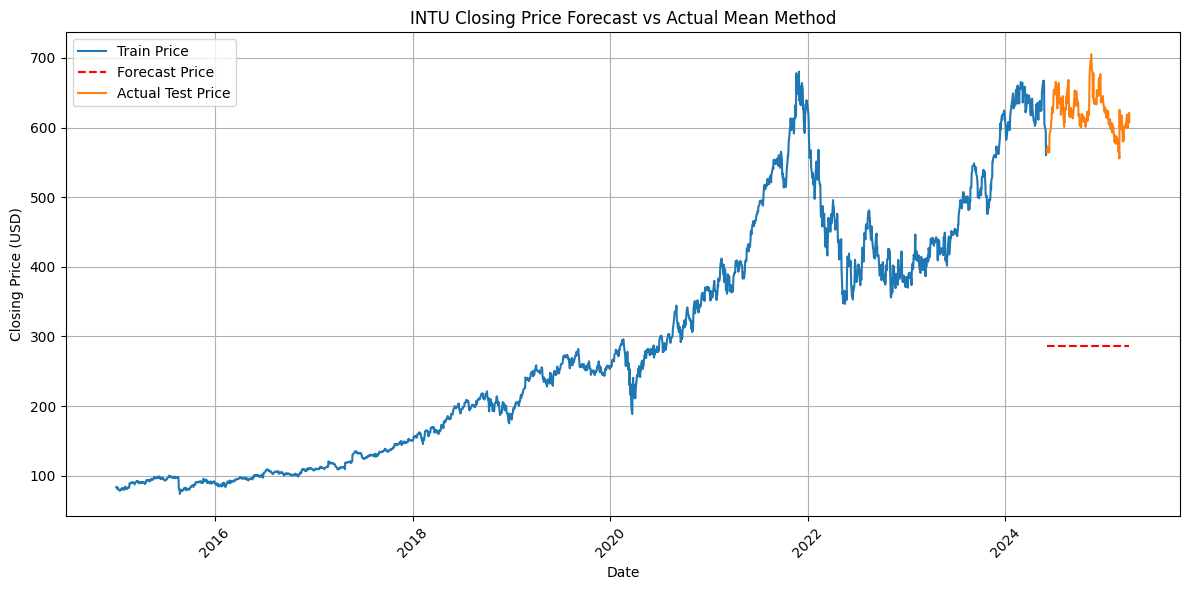

-------------Accuracy Scores-------------
RMSE: 333.32
MAE: 331.54
R-squared: -92.93


In [14]:
# Mean method:
mean = data_train.mean().iloc[0]
forecast = pd.DataFrame({
    'Close' : [mean for x in range(len(future_days))]
}, index=future_days)

plot_prediction(data_train, forecast, data_test, 'Mean Method')

# Checking accuracy scores for the first 30 days forecast
print_accuracy_scores(data_test['Close'][:30].values, forecast['Close'][:30].values)

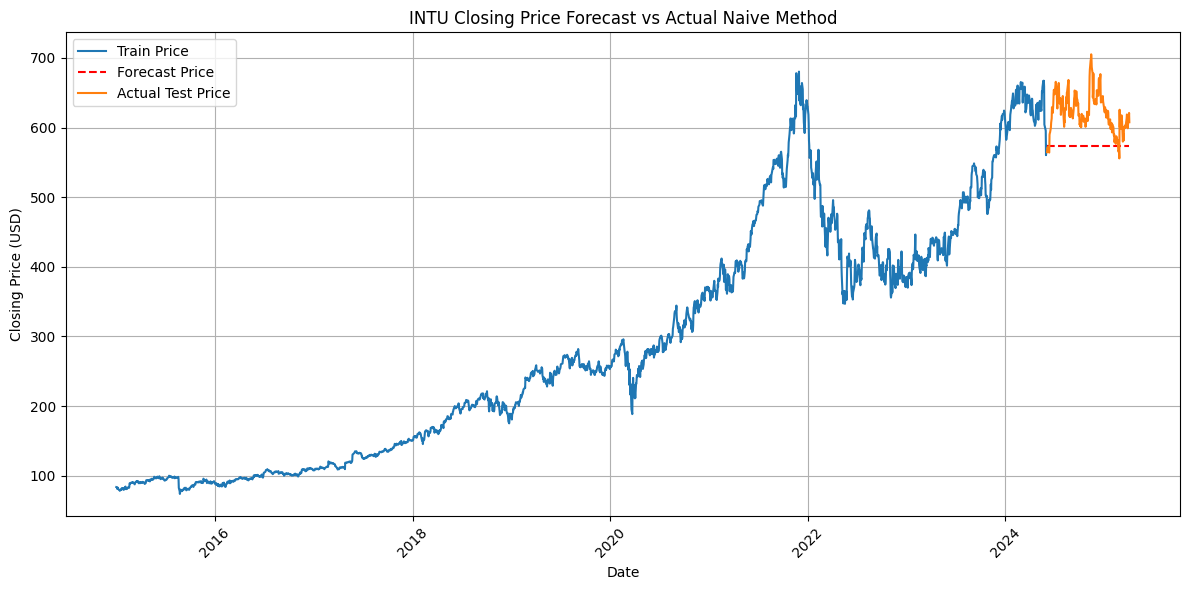

-------------Accuracy Scores-------------
RMSE: 55.76
MAE: 46.61
R-squared: -1.63


In [15]:
# Naive Method
last_price = data_train.iloc[-1]['Close']
forecast = pd.DataFrame({
    'Close' : [last_price for x in range(len(future_days))]
}, index=future_days)

plot_prediction(data_train, forecast, data_test, 'Naive Method')

# Checking accuracy scores for the first 30 days forecast
print_accuracy_scores(data_test['Close'][:30].values, forecast['Close'][:30].values)

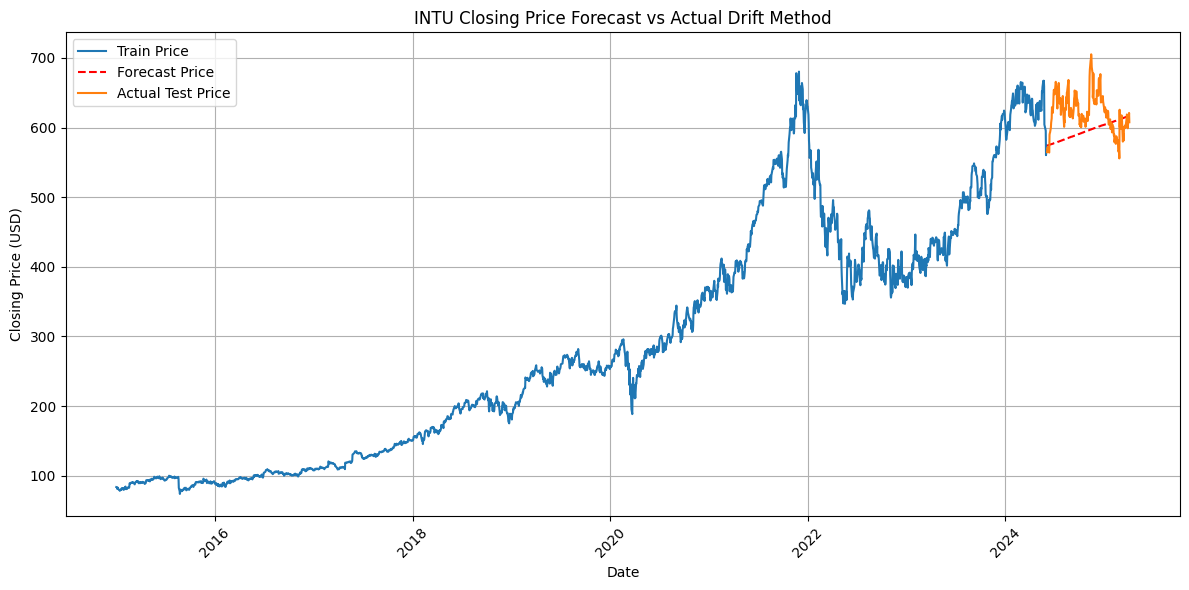

-------------Accuracy Scores-------------
RMSE: 52.40
MAE: 43.90
R-squared: -1.32


In [16]:
# Drift Method
slope = (data_train.iloc[-1]['Close'] - data_train.iloc[0]['Close']) / len(data_train)
def drift_function(x):
    return slope * x + data_train.iloc[0]['Close']

forecast = pd.DataFrame({
    'Close' : [drift_function(x + len(data_train)) for x in range(len(future_days))]
}, index=future_days)

plot_prediction(data_train, forecast, data_test, 'Drift Method')

# Checking accuracy scores for the first 30 days forecast
print_accuracy_scores(data_test['Close'][:30].values, forecast['Close'][:30].values)

We can see that our Drift model gave us the best accuracy scores so we will go with that one for our Benchmark

Now we'll look at some more advanced models

In [17]:
#Linear Regression model to predict next 30 days

days = np.arange(len(data_train)).reshape(-1, 1)  # Reshape for sklearn
prices = data_train.values.reshape(-1, 1)

In [18]:
# Create and train the linear regression model
model = LinearRegression()
model.fit(days, prices)


LinearRegression()

In [19]:
# Predict the next days
last_day = days[-1][0]
future_days_int = np.arange(last_day + 1, last_day + 1 + len(future_days)).reshape(-1, 1)
future_prices = model.predict(future_days_int)

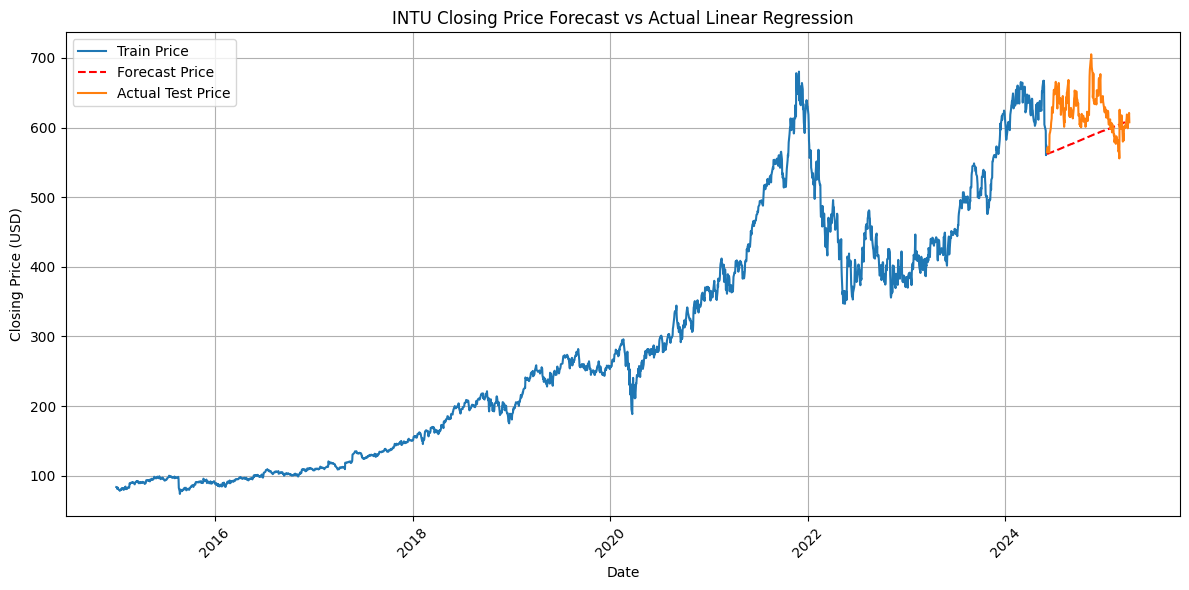

-------------Accuracy Scores-------------
RMSE: 61.81
MAE: 52.53
R-squared: -2.23


In [20]:
forecast = pd.DataFrame({
    'Close' : future_prices.reshape((len(future_days)))
}, index=future_days)


plot_prediction(data_train, forecast, data_test, 'Linear Regression')

# Checking accuracy scores for the first 30 days forecast
print_accuracy_scores(data_test['Close'][:30].values, future_prices[:30].reshape((30)))

Our Linear model perform slightly worse than our Benchmark so we will explore some other models.

Next we'll try an ARIMA model.

In [21]:
# Let's do a grid search to find our best ARIMA model:
grid_results = []
search_grid_pdq = [5, 3, 5]
count = 0
for p in range(search_grid_pdq[0]):
    for d in range(search_grid_pdq[1]):
        for q in range(search_grid_pdq[2]):
            print(f'{count + 1} of {search_grid_pdq[0]*search_grid_pdq[1]*search_grid_pdq[2]}', end='\r')
            count += 1
            try:
                model = ARIMA(data_train, order=(p,d,q))
                results = model.fit()
                grid_results.append([p, d, q, results.aic, results.bic])
            except:
                pass

75 of 75

In [22]:
results = pd.DataFrame(grid_results, columns=['p','d','q','aic','bic'])

display(results.sort_values('aic')[:5])
display(results.sort_values('bic')[:5])

,p,d,q,aic,bic
53,3,1,3,15954.805478,15995.194085
68,4,1,3,15956.676408,16002.834816
24,1,1,4,15957.033031,15991.651837
43,2,2,3,15957.201676,15991.817948
66,4,1,1,15957.695006,15992.313812


,p,d,q,aic,bic
5,0,1,0,15970.394635,15976.164436
6,0,1,1,15967.046442,15978.586044
20,1,1,0,15967.054714,15978.594316
11,0,2,1,15972.398421,15983.937178
12,0,2,2,15968.940488,15986.248624


We'll pick ARIMA(3,1,3) after the best AIC score.

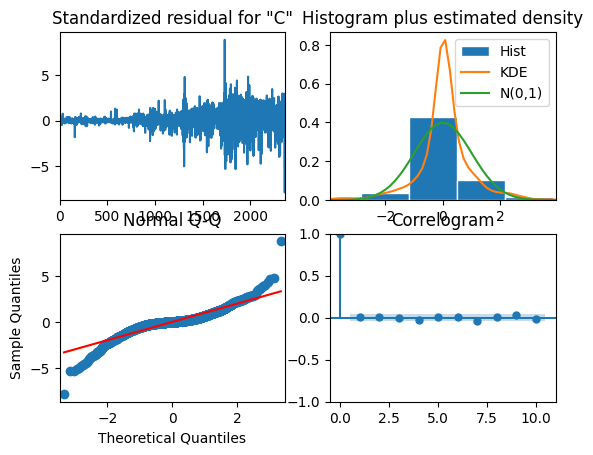

In [23]:
model = ARIMA(data_train, order=(3,1,3))
model_fit = model.fit()

fig = model_fit.plot_diagnostics()

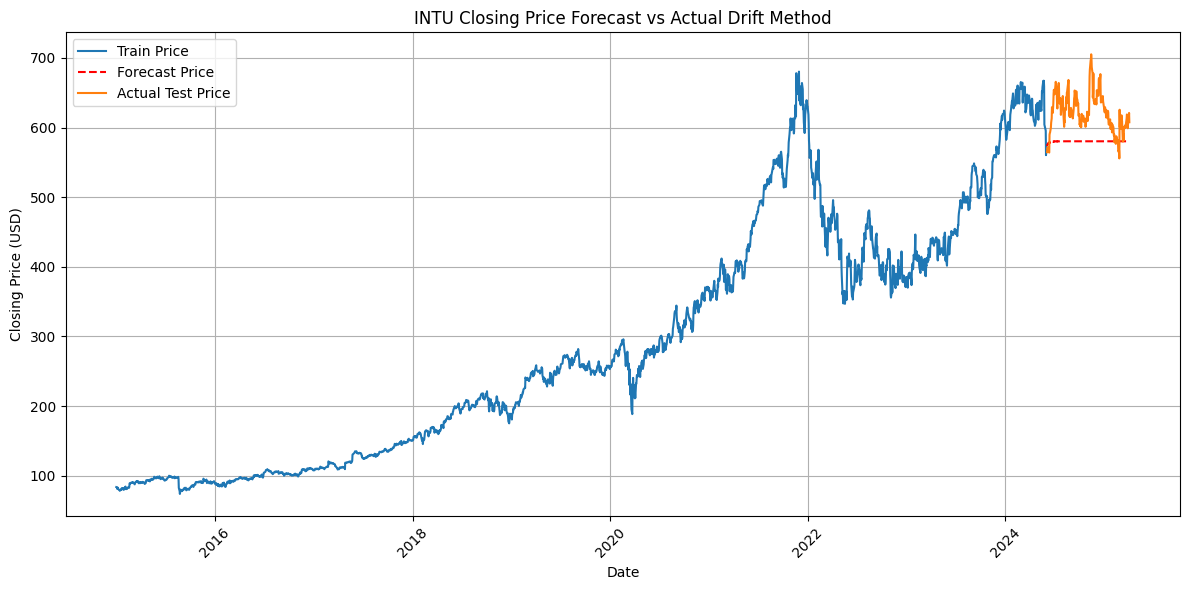

-------------Accuracy Scores-------------
RMSE: 61.81
MAE: 52.53
R-squared: -2.23


In [24]:
# Let's make predictions and calculate the accuracy scores
forecast = pd.DataFrame({
    'Close' : model_fit.forecast(steps=len(future_days)).values
}, index=future_days)


plot_prediction(data_train, forecast, data_test, 'Drift Method')

# Checking accuracy scores for the first 30 days forecast
print_accuracy_scores(data_test['Close'][:30].values, future_prices[:30].reshape((30)))

In [25]:
# Show the Next 30 Days prediction based on Linear Model
future_predictions_df = pd.DataFrame(future_prices, index=future_days, columns=['Predicted Close'])
print(future_predictions_df[:30])

            Predicted Close
Date                       
2024-06-03       561.712300
2024-06-04       561.944906
2024-06-05       562.177511
2024-06-06       562.410117
2024-06-07       562.642722
2024-06-10       562.875328
2024-06-11       563.107933
2024-06-12       563.340539
2024-06-13       563.573144
2024-06-14       563.805750
2024-06-17       564.038355
2024-06-18       564.270961
2024-06-20       564.503566
2024-06-21       564.736172
2024-06-24       564.968777
2024-06-25       565.201383
2024-06-26       565.433988
2024-06-27       565.666594
2024-06-28       565.899199
2024-07-01       566.131805
2024-07-02       566.364410
2024-07-03       566.597016
2024-07-05       566.829621
2024-07-08       567.062227
2024-07-09       567.294832
2024-07-10       567.527438
2024-07-11       567.760043
2024-07-12       567.992649
2024-07-15       568.225254
2024-07-16       568.457860
